[ 2.24918724e-08 -8.79840236e-08]
[0.00016958 0.00012682]
[0.00046673 0.00034929]
[0.00091229 0.0006825 ]
[0.00152271 0.00113776]
[0.00231102 0.00172291]
[0.0032876  0.00244286]
[0.00446084 0.0032999 ]
[0.00583762 0.00429409]
[0.00742372 0.0054235 ]
[0.00922408 0.00668446]
[0.01124306 0.0080718 ]
[0.01348458 0.00957897]
[0.01595226 0.01119825]
[0.01864942 0.01292087]
[0.02157923 0.0147371 ]
[0.02474462 0.01663639]
[0.02814835 0.01860746]
[0.03179297 0.02063832]
[0.03568079 0.02271646]
[0.0398139 0.0248288]
[0.04419406 0.02696184]
[0.04882274 0.02910167]
[0.05370106 0.03123404]
[0.05882973 0.03334439]
[0.06420909 0.03541795]
[0.06983901 0.03743969]
[0.07571894 0.03939445]
[0.08184782 0.0412669 ]
[0.08822413 0.0430416 ]
[0.09484582 0.04470303]
[0.10171038 0.04623557]
[0.10881476 0.04762356]
[0.11615541 0.04885128]
[0.1237283  0.04990299]
[0.13152888 0.05076288]
[0.13955215 0.05141513]
[0.14779263 0.05184386]
[0.15624438 0.05203315]
[0.16490104 0.05196704]
[0.17375584 0.05162949]
[0.18280

/tmp/ipykernel_25454/2599452794.py:141: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.true_eff.set_data(x_true[-1], y_true[-1])
/tmp/ipykernel_25454/2599452794.py:148: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.ref_eff.set_data(x_ref[-1], y_ref[-1])


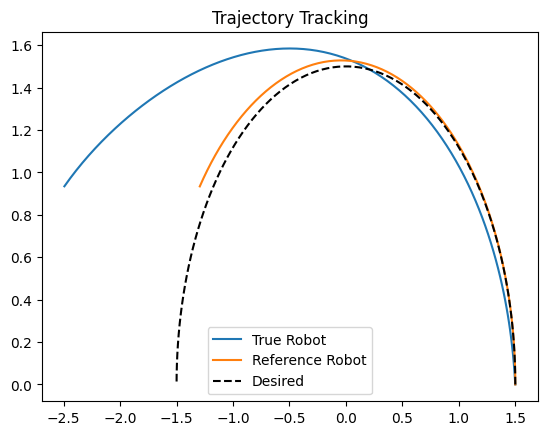

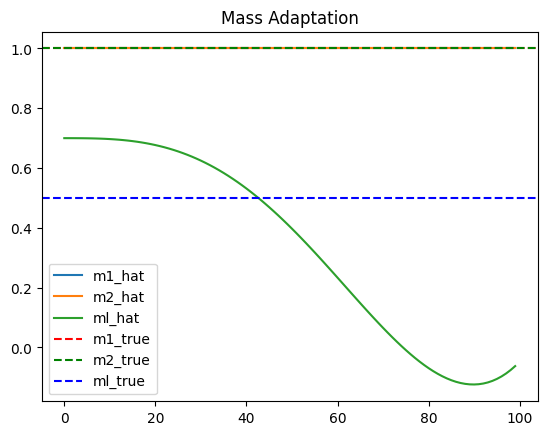

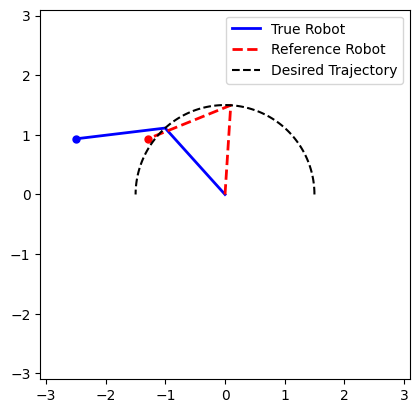

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def forward_kinematics(q, l1, l2):
    q1, q2 = q
    x = l1 * np.cos(q1) + l2 * np.cos(q1 + q2)
    y = l1 * np.sin(q1) + l2 * np.sin(q1 + q2)
    return (x, y)

def inverse_kinematics(x, y, l1, l2):
    c2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    if abs(c2) > 1:
        raise ValueError("Target position out of reachable workspace")
    s2 = np.sqrt(1 - c2**2)  # Elbow-down configuration
    q2 = np.arctan2(s2, c2)
    alpha = np.arctan2(y, x)
    beta = np.arctan2(l2 * s2, l1 + l2 * c2)
    q1 = alpha - beta
    return np.array([q1, q2])

def generate_circular_trajectory(center, radius, num_points):
    theta = np.linspace(0, np.pi, num_points)  # Half-circle
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return list(zip(x, y))

class Robot:
    def __init__(self, l1, l2, m1, m2, ml, dt, q0, gravity=9.81):
        self.l1 = l1
        self.l2 = l2
        self.m1 = m1
        self.m2 = m2
        self.ml = ml
        self.dt = dt
        self.g = gravity
        self.q = q0  # Initial angles
        self.dq = np.array([0.0, 0.0])  # Initial velocities

    def compute_M(self, q):
        q1, q2 = q
        l1, l2, m1, m2, ml = self.l1, self.l2, self.m1, self.m2, self.ml
        lc1, lc2 = l1 / 2, l2 / 2
        I1 = (1/12) * m1 * l1**2
        I2 = (1/12) * m2 * l2**2
        M11 = (m1 * lc1**2 + I1) + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * np.cos(q2)) + I2 + ml * (l1**2 + l2**2 + 2 * l1 * l2 * np.cos(q2))
        M12 = m2 * (lc2**2 + l1 * lc2 * np.cos(q2)) + I2 + ml * (l2**2 + l1 * l2 * np.cos(q2))
        M22 = m2 * lc2**2 + I2 + ml * l2**2
        return np.array([[M11, M12], [M12, M22]])

    def compute_C(self, q, dq):
        q1, q2 = q
        dq1, dq2 = dq
        l1, l2, m1, m2, ml = self.l1, self.l2, self.m1, self.m2, self.ml
        term = (m2 * l1 * (l2 / 2) + ml * l1 * l2) * np.sin(q2)
        C1 = -term * (2 * dq1 * dq2 + dq2**2)
        C2 = term * dq1**2
        return np.array([C1, C2])

    def compute_G(self, q):
        q1, q2 = q
        l1, l2, m1, m2, ml, g = self.l1, self.l2, self.m1, self.m2, self.ml, self.g
        G1 = (m1 * (l1 / 2) + m2 * l1 + ml * l1) * g * np.cos(q1) + (m2 * (l2 / 2) + ml * l2) * g * np.cos(q1 + q2)
        G2 = (m2 * (l2 / 2) + ml * l2) * g * np.cos(q1 + q2)
        return np.array([G1, G2])

    def forward(self, tau):
        M = self.compute_M(self.q)
        C = self.compute_C(self.q, self.dq)
        G = self.compute_G(self.q)
        qdd = np.linalg.inv(M) @ (tau - C - G)
        self.dq += qdd * self.dt
        self.q += self.dq * self.dt
        self.q = (self.q + np.pi) % (2 * np.pi) - np.pi
        return self.q.copy(), self.dq.copy()

class Controller:
    def __init__(self, l1, l2, m1_hat, m2_hat, ml_hat, Kp, Kd, dt, gravity=9.81):
        self.l1 = l1
        self.l2 = l2
        self.m1_hat = m1_hat
        self.m2_hat = m2_hat
        self.ml_hat = ml_hat
        self.Kp = Kp
        self.Kd = Kd
        self.dt = dt
        self.g = gravity

    def compute_torque(self, q_current, dq_current, q_desired):
        q_error = q_desired - q_current
        dq_desired = np.zeros_like(dq_current)
        dq_error = dq_desired - dq_current
        qdd_desired = self.Kp * q_error + self.Kd * dq_error
        temp_robot = Robot(self.l1, self.l2, self.m1_hat, self.m2_hat, self.ml_hat, self.dt, self.g)
        temp_robot.q = q_current
        temp_robot.dq = dq_current
        M_hat = temp_robot.compute_M(q_current)
        C_hat = temp_robot.compute_C(q_current, dq_current)
        G_hat = temp_robot.compute_G(q_current)
        tau = M_hat @ qdd_desired + C_hat + G_hat
        return tau

    def update_masses(self, e, gamma):
        #self.m1_hat += gamma * e[0]
        #self.m2_hat += gamma * e[1]
        self.ml_hat += gamma * (e[0] + e[1])
        print(e)

class Animator:
    def __init__(self, true_joints, ref_joints, l1, l2, trajectory, dt):
        self.true_joints = true_joints
        self.ref_joints = ref_joints
        self.l1 = l1
        self.l2 = l2
        self.trajectory = trajectory
        self.dt = dt
        self.fig, self.ax = plt.subplots()
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-(l1 + l2 + 0.1), l1 + l2 + 0.1)
        self.ax.set_ylim(-(l1 + l2 + 0.1), l1 + l2 + 0.1)
        self.true_line, = self.ax.plot([], [], 'b-', lw=2, label='True Robot')
        self.ref_line, = self.ax.plot([], [], 'r--', lw=2, label='Reference Robot')
        self.true_eff, = self.ax.plot([], [], 'bo', markersize=5)
        self.ref_eff, = self.ax.plot([], [], 'ro', markersize=5)
        self.traj_line, = self.ax.plot(*zip(*trajectory), 'k--', label='Desired Trajectory')
        self.ax.legend()

    def init(self):
        self.true_line.set_data([], [])
        self.ref_line.set_data([], [])
        self.true_eff.set_data([], [])
        self.ref_eff.set_data([], [])
        return self.true_line, self.ref_line, self.true_eff, self.ref_eff

    def update(self, frame):
        # Update true robot
        q_true = self.true_joints[frame]
        x_true = [0, self.l1 * np.cos(q_true[0]), self.l1 * np.cos(q_true[0]) + self.l2 * np.cos(q_true[0] + q_true[1])]
        y_true = [0, self.l1 * np.sin(q_true[0]), self.l1 * np.sin(q_true[0]) + self.l2 * np.sin(q_true[0] + q_true[1])]
        self.true_line.set_data(x_true, y_true)
        self.true_eff.set_data(x_true[-1], y_true[-1])

        # Update reference robot
        q_ref = self.ref_joints[frame]
        x_ref = [0, self.l1 * np.cos(q_ref[0]), self.l1 * np.cos(q_ref[0]) + self.l2 * np.cos(q_ref[0] + q_ref[1])]
        y_ref = [0, self.l1 * np.sin(q_ref[0]), self.l1 * np.sin(q_ref[0]) + self.l2 * np.sin(q_ref[0] + q_ref[1])]
        self.ref_line.set_data(x_ref, y_ref)
        self.ref_eff.set_data(x_ref[-1], y_ref[-1])

        return self.true_line, self.ref_line, self.true_eff, self.ref_eff

    def animate(self):
        ani = animation.FuncAnimation(
            self.fig, 
            self.update, 
            frames=len(self.true_joints),
            init_func=self.init,
            blit=True,
            interval=self.dt * 1000
        )
        ani.save('robot_animation.gif', writer='pillow', fps=30)

# Parameters
l1, l2 = 1.5, 1.5
dt = 0.01
m1_true, m2_true, ml_true = 1.0, 1.0, 0.5
m1_hat, m2_hat, ml_hat = 1.0, 1.0, 0.7
#m1_hat, m2_hat, ml_hat = 1.0, 1.0, 0.5
Kp, Kd = 100.0, 20.0
gamma = -0.05

# Generate trajectory
trajectory = generate_circular_trajectory((0.0, 0.0), (l1 + l2)/2, 100)

# Initialize robots and controller
q0 = inverse_kinematics(trajectory[0][0], trajectory[0][1], l1, l2)
true_robot = Robot(l1, l2, m1_true, m2_true, ml_true, dt, q0)
ref_robot = Robot(l1, l2, m1_hat, m2_hat, ml_hat, dt, q0)
controller = Controller(l1, l2, m1_hat, m2_hat, ml_hat, Kp, Kd, dt)

# Simulation
true_positions, ref_positions = [], []
true_joints, ref_joints = [], []
m1_history, m2_history, ml_history = [], [], []

for point in trajectory:
    x_des, y_des = point
    try:
        q_desired = inverse_kinematics(x_des, y_des, l1, l2)
    except ValueError:
        break
    q_ref, dq_ref = ref_robot.q, ref_robot.dq
    tau = controller.compute_torque(q_ref, dq_ref, q_desired)
    true_q, _ = true_robot.forward(tau)
    ref_q, _ = ref_robot.forward(tau)
    e = true_q - ref_q
    controller.update_masses(e, gamma)
    true_joints.append(true_q)
    ref_joints.append(ref_q)
    true_positions.append(forward_kinematics(true_q, l1, l2))
    ref_positions.append(forward_kinematics(ref_q, l1, l2))
    m1_history.append(controller.m1_hat)
    m2_history.append(controller.m2_hat)
    ml_history.append(controller.ml_hat)

# Plotting
plt.figure()
plt.plot(*zip(*true_positions), label='True Robot')
plt.plot(*zip(*ref_positions), label='Reference Robot')
plt.plot(*zip(*trajectory), 'k--', label='Desired')
plt.legend()
plt.title('Trajectory Tracking')

plt.figure()
plt.plot(m1_history, label='m1_hat')
plt.plot(m2_history, label='m2_hat')
plt.plot(ml_history, label='ml_hat')
plt.axhline(m1_true, color='r', linestyle='--', label='m1_true')
plt.axhline(m2_true, color='g', linestyle='--', label='m2_true')
plt.axhline(ml_true, color='b', linestyle='--', label='ml_true')
plt.legend()
plt.title('Mass Adaptation')

# Create and save animation
animator = Animator(true_joints, ref_joints, l1, l2, trajectory, dt)
animator.animate()

plt.show()

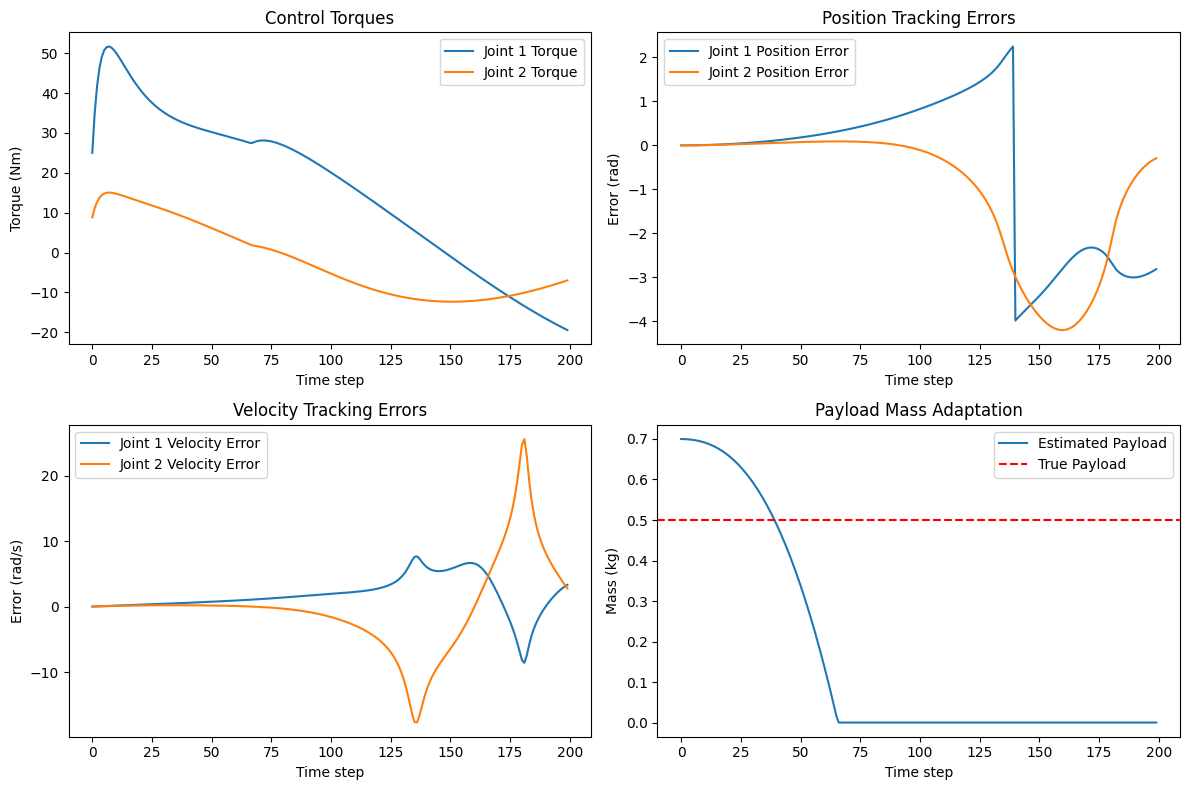

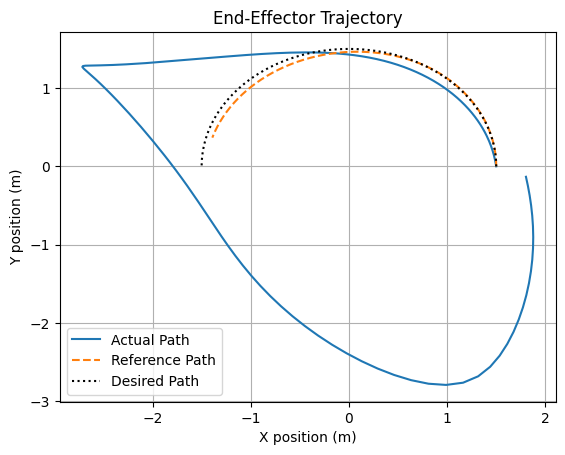

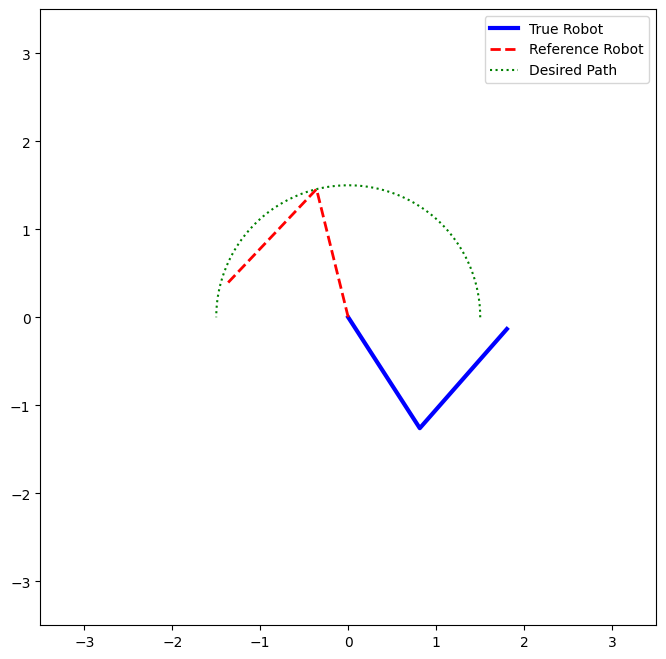


Possible reasons:
1. Insufficient PD gains (Kp/Kd too low)
2. Improper adaptation rate (gamma too high/low)
3. Unmodeled dynamics (friction, joint limits)
4. Overcompensation in adaptive parameters
5. Discrete-time implementation issues


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Forward kinematics: Convert joint angles to end-effector position
def forward_kinematics(q, l1, l2):
    q1, q2 = q
    x = l1 * np.cos(q1) + l2 * np.cos(q1 + q2)
    y = l1 * np.sin(q1) + l2 * np.sin(q1 + q2)
    return (x, y)

# Inverse kinematics: Convert end-effector position to joint angles
def inverse_kinematics(x, y, l1, l2):
    c2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    if abs(c2) > 1:
        raise ValueError("Target position out of reachable workspace")
    s2 = np.sqrt(1 - c2**2)  # Elbow-down configuration
    q2 = np.arctan2(s2, c2)
    alpha = np.arctan2(y, x)
    beta = np.arctan2(l2 * s2, l1 + l2 * c2)
    q1 = alpha - beta
    return np.array([q1, q2])

# Generate circular trajectory points
def generate_circular_trajectory(center, radius, num_points):
    theta = np.linspace(0, np.pi, num_points)  # Half-circle
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return list(zip(x, y))

class Robot:
    """2DOF robotic arm dynamics model"""
    def __init__(self, l1, l2, m1, m2, ml, dt, q0, gravity=9.81):
        self.l1 = l1      # Length of first link
        self.l2 = l2      # Length of second link
        self.m1 = m1      # Mass of first link
        self.m2 = m2      # Mass of second link
        self.ml = ml      # Payload mass
        self.dt = dt      # Time step
        self.g = gravity  # Gravity constant
        self.q = q0       # Joint angles [q1, q2]
        self.dq = np.array([0.0, 0.0])  # Joint velocities

    def compute_M(self, q):
        """Compute mass matrix"""
        q1, q2 = q
        l1, l2, m1, m2, ml = self.l1, self.l2, self.m1, self.m2, self.ml
        lc1, lc2 = l1/2, l2/2  # Center of mass positions
        
        # Moments of inertia
        I1 = (1/12)*m1*l1**2
        I2 = (1/12)*m2*l2**2
        
        # Mass matrix components
        M11 = m1*lc1**2 + I1 + m2*(l1**2 + lc2**2 + 2*l1*lc2*np.cos(q2)) + ml*(l1**2 + l2**2 + 2*l1*l2*np.cos(q2)) + I2
        M12 = m2*(lc2**2 + l1*lc2*np.cos(q2)) + ml*(l2**2 + l1*l2*np.cos(q2)) + I2
        M22 = m2*lc2**2 + ml*l2**2 + I2
        return np.array([[M11, M12], [M12, M22]])

    def compute_C(self, q, dq):
        """Compute Coriolis/centrifugal forces"""
        q1, q2 = q
        dq1, dq2 = dq
        l1, l2, m1, m2, ml = self.l1, self.l2, self.m1, self.m2, self.ml
        term = (m2*l1*(l2/2) + ml*l1*l2) * np.sin(q2)
        return np.array([
            -term*(2*dq1*dq2 + dq2**2),  # C1
            term*dq1**2                  # C2
        ])

    def compute_G(self, q):
        """Compute gravitational forces"""
        q1, q2 = q
        l1, l2, m1, m2, ml, g = self.l1, self.l2, self.m1, self.m2, self.ml, self.g
        return np.array([
            (m1*(l1/2) + m2*l1 + ml*l1)*g*np.cos(q1) + (m2*(l2/2) + ml*l2)*g*np.cos(q1+q2),  # G1
            (m2*(l2/2) + ml*l2)*g*np.cos(q1+q2)  # G2
        ])

    def forward(self, tau):
        """Perform forward dynamics computation"""
        M = self.compute_M(self.q)
        C = self.compute_C(self.q, self.dq)
        G = self.compute_G(self.q)
        qdd = np.linalg.inv(M) @ (tau - C - G)
        self.dq += qdd * self.dt
        self.q += self.dq * self.dt
        self.q = (self.q + np.pi) % (2*np.pi) - np.pi  # Normalize angles
        return self.q.copy(), self.dq.copy()

class Controller:
    """Adaptive controller with MRAC"""
    def __init__(self, l1, l2, m1_hat, m2_hat, ml_hat, Kp, Kd, dt, gravity=9.81):
        self.l1 = l1          # Link lengths
        self.l2 = l2
        self.m1_hat = m1_hat  # Estimated masses
        self.m2_hat = m2_hat
        self.ml_hat = ml_hat
        self.Kp = Kp          # PD gains
        self.Kd = Kd
        self.dt = dt          # Time step
        self.g = gravity

    def compute_torque(self, q_current, dq_current, q_desired):
        """Compute control torque using inverse dynamics"""
        q_error = q_desired - q_current
        dq_error = -dq_current  # Target velocity is zero for setpoint control
        qdd_desired = self.Kp * q_error + self.Kd * dq_error
        
        # Create temporary robot with estimated parameters
        temp_robot = Robot(self.l1, self.l2, self.m1_hat, self.m2_hat, 
                          self.ml_hat, self.dt, q_current, self.g)
        temp_robot.dq = dq_current
        
        # Calculate estimated dynamics
        M_hat = temp_robot.compute_M(q_current)
        C_hat = temp_robot.compute_C(q_current, dq_current)
        G_hat = temp_robot.compute_G(q_current)
        
        return M_hat @ qdd_desired + C_hat + G_hat

    def update_masses(self, e_pos, e_vel, gamma):
        """Enhanced adaptation law using both position and velocity errors"""
        # Composite error combining position and velocity errors
        composite_error = np.sum(np.abs(e_pos)) + 0.1*np.sum(np.abs(e_vel))
        
        # Adaptive update rule with momentum term
        self.ml_hat += gamma * composite_error
        self.ml_hat = max(min(self.ml_hat, 2.0), 0.0)  # Clamp values

class Animator:
    """Animation visualization class"""
    def __init__(self, true_joints, ref_joints, l1, l2, trajectory, dt):
        self.true_joints = true_joints  # True joint angles history
        self.ref_joints = ref_joints    # Reference joint angles history
        self.l1 = l1
        self.l2 = l2
        self.trajectory = trajectory
        self.dt = dt
        
        # Initialize figure
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-(l1+l2+0.5), l1+l2+0.5)
        self.ax.set_ylim(-(l1+l2+0.5), l1+l2+0.5)
        
        # Initialize plot elements
        self.true_line, = self.ax.plot([], [], 'b-', lw=3, label='True Robot')
        self.ref_line, = self.ax.plot([], [], 'r--', lw=2, label='Reference Robot')
        self.traj_line, = self.ax.plot(*zip(*trajectory), 'g:', label='Desired Path')
        self.ax.legend()

    def init(self):
        """Initialize animation frame"""
        self.true_line.set_data([], [])
        self.ref_line.set_data([], [])
        return self.true_line, self.ref_line

    def update(self, frame):
        """Update animation frame"""
        # Update true robot
        q_true = self.true_joints[frame]
        x_true = [0, 
                 self.l1*np.cos(q_true[0]), 
                 self.l1*np.cos(q_true[0]) + self.l2*np.cos(q_true[0]+q_true[1])]
        y_true = [0,
                 self.l1*np.sin(q_true[0]),
                 self.l1*np.sin(q_true[0]) + self.l2*np.sin(q_true[0]+q_true[1])]
        self.true_line.set_data(x_true, y_true)
        
        # Update reference robot
        q_ref = self.ref_joints[frame]
        x_ref = [0,
                self.l1*np.cos(q_ref[0]),
                self.l1*np.cos(q_ref[0]) + self.l2*np.cos(q_ref[0]+q_ref[1])]
        y_ref = [0,
                self.l1*np.sin(q_ref[0]),
                self.l1*np.sin(q_ref[0]) + self.l2*np.sin(q_ref[0]+q_ref[1])]
        self.ref_line.set_data(x_ref, y_ref)
        
        return self.true_line, self.ref_line

    def animate(self):
        """Create and save animation"""
        ani = animation.FuncAnimation(
            self.fig, self.update,
            frames=len(self.true_joints),
            init_func=self.init,
            blit=True,
            interval=self.dt*1000
        )
        ani.save('robot_tracking.gif', writer='pillow', fps=30)

# Simulation parameters
l1, l2 = 1.5, 1.5       # Link lengths
dt = 0.01                # Time step
m1_true, m2_true = 1.0, 1.0  # True link masses
ml_true = 0.5            # True payload mass
ml_hat = 0.7             # Initial payload estimate
Kp, Kd = 150.0, 30.0    # PD gains
gamma = 0.05             # Adaptation rate

# Generate circular trajectory
trajectory = generate_circular_trajectory((0, 0), (l1+l2)/2, 200)

# Initialize systems
try:
    q0 = inverse_kinematics(trajectory[0][0], trajectory[0][1], l1, l2)
except ValueError as e:
    print(f"Initial position error: {e}")
    exit()

true_robot = Robot(l1, l2, m1_true, m2_true, ml_true, dt, q0)
ref_robot = Robot(l1, l2, m1_true, m2_true, ml_hat, dt, q0)
controller = Controller(l1, l2, m1_true, m2_true, ml_hat, Kp, Kd, dt)

# Data logging
history = {
    'true_pos': [], 'ref_pos': [],
    'true_q': [], 'ref_q': [],
    'tau1': [], 'tau2': [],
    'pos_error': [], 'vel_error': [],
    'ml_hat': []
}

# Main control loop
for idx, point in enumerate(trajectory):
    # Get desired joint angles
    try:
        q_desired = inverse_kinematics(point[0], point[1], l1, l2)
    except ValueError:
        print(f"Trajectory point {idx} unreachable")
        break

    # Compute control torque
    tau = controller.compute_torque(ref_robot.q, ref_robot.dq, q_desired)
    
    # Apply torque to both robots
    true_q, true_dq = true_robot.forward(tau)
    ref_q, ref_dq = ref_robot.forward(tau)
    
    # Calculate errors
    e_pos = true_q - ref_q
    e_vel = true_dq - ref_dq
    
    # Update mass estimates
    controller.update_masses(e_pos, e_vel, gamma)
    
    # Log data
    history['true_pos'].append(forward_kinematics(true_q, l1, l2))
    history['ref_pos'].append(forward_kinematics(ref_q, l1, l2))
    history['true_q'].append(true_q)
    history['ref_q'].append(ref_q)
    history['tau1'].append(tau[0])
    history['tau2'].append(tau[1])
    history['pos_error'].append(e_pos)
    history['vel_error'].append(e_vel)
    history['ml_hat'].append(controller.ml_hat)

# Analysis plots
plt.figure(figsize=(12, 8))

# Torque plot
plt.subplot(2, 2, 1)
plt.plot(history['tau1'], label='Joint 1 Torque')
plt.plot(history['tau2'], label='Joint 2 Torque')
plt.title('Control Torques')
plt.xlabel('Time step')
plt.ylabel('Torque (Nm)')
plt.legend()

# Position error plot
plt.subplot(2, 2, 2)
pos_errors = np.array(history['pos_error'])
plt.plot(pos_errors[:, 0], label='Joint 1 Position Error')
plt.plot(pos_errors[:, 1], label='Joint 2 Position Error')
plt.title('Position Tracking Errors')
plt.xlabel('Time step')
plt.ylabel('Error (rad)')
plt.legend()

# Velocity error plot
plt.subplot(2, 2, 3)
vel_errors = np.array(history['vel_error'])
plt.plot(vel_errors[:, 0], label='Joint 1 Velocity Error')
plt.plot(vel_errors[:, 1], label='Joint 2 Velocity Error')
plt.title('Velocity Tracking Errors')
plt.xlabel('Time step')
plt.ylabel('Error (rad/s)')
plt.legend()

# Mass adaptation plot
plt.subplot(2, 2, 4)
plt.plot(history['ml_hat'], label='Estimated Payload')
plt.axhline(ml_true, color='r', linestyle='--', label='True Payload')
plt.title('Payload Mass Adaptation')
plt.xlabel('Time step')
plt.ylabel('Mass (kg)')
plt.legend()

plt.tight_layout()

# Trajectory tracking plot
plt.figure()
plt.plot(*zip(*history['true_pos']), label='Actual Path')
plt.plot(*zip(*history['ref_pos']), '--', label='Reference Path')
plt.plot(*zip(*trajectory), 'k:', label='Desired Path')
plt.title('End-Effector Trajectory')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.legend()
plt.grid(True)

# Create animation
animator = Animator(history['true_q'], history['ref_q'], l1, l2, trajectory, dt)
animator.animate()

plt.show()

# Analyze error growth
final_pos_error = np.linalg.norm(pos_errors[-10:])
if final_pos_error > np.linalg.norm(pos_errors[:10]):
    print("\nWarning: Position error is increasing over time!")
    print("Possible reasons:")
    print("1. Insufficient PD gains (Kp/Kd too low)")
    print("2. Improper adaptation rate (gamma too high/low)")
    print("3. Unmodeled dynamics (friction, joint limits)")
    print("4. Overcompensation in adaptive parameters")
    print("5. Discrete-time implementation issues")